<a href="https://colab.research.google.com/github/sayan0506/Image-Denoising-Using-Autoencoder/blob/master/Autoencoder_for_image_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Denoising using Autoencoder

In [1]:
# Installing livelossplot module for dynamical plot of model training
!pip install git+git://github.com/stared/livelossplot.git

  Cloning git://github.com/stared/livelossplot.git to /tmp/pip-req-build-ahjnw2i1
  Running command git clone -q git://github.com/stared/livelossplot.git /tmp/pip-req-build-ahjnw2i1
  Created wheel for livelossplot: filename=livelossplot-0.5.3-cp36-none-any.whl size=22611 sha256=a8eee6c7f966ee73039a8b9a1b86afaf275a6a04702240751504d32a7b5329e1
  Stored in directory: /tmp/pip-ephem-wheel-cache-f3r1ciu2/wheels/77/01/ea/cef3581d9c77ece0fd685cc3eb1cd92dc68d8117b361ac65dc
Successfully built livelossplot


# Importing libraries and dataset

## Importing modules

In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import random
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
from livelossplot.tf_keras import  PlotLossesCallback

print('Tensorflow version: ',tf.version.VERSION)

Tensorflow version:  2.3.0


## Loading the fashion MNIST dataset

In [3]:
# load dataset
(x_train, y_train),(x_test,y_test) = keras.datasets.fashion_mnist.load_data()
print('Shape of the dataset\nTrain input: {0}\nTrain label: {1}\nTest input: {2}\n Test label: {3}'.format(x_train.shape,y_train.shape, x_test.shape, y_test.shape))

4423680/4422102 [==============================] - 0s 0us/step
Shape of the dataset
Train input: (60000, 28, 28)
Train label: (60000,)
Test input: (10000, 28, 28)
 Test label: (10000,)


In [4]:
# Creating the labels list
label_list = ['T-shirt','Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

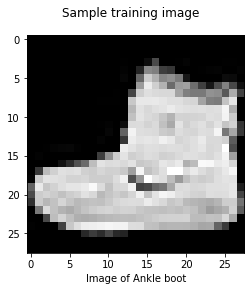

In [5]:
# Visualize sample image
plt.suptitle('Sample training image')
plt.imshow(x_train[0].reshape(28,28), cmap = 'gray')
plt.xlabel('Image of {0}'.format(label_list[y_train[0]]))
plt.show()

# Images Visualization

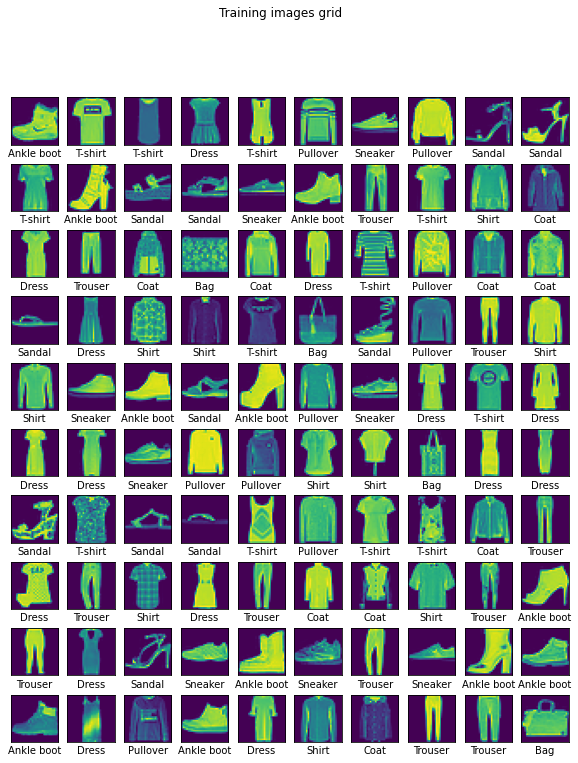

In [6]:
# no of images in horizontal row
x_grid = 10
# no of images vertical row
y_grid = 10

# function which takes only horizontal and vertical row values for training image visualization
def img_vis(dataset_x, dataset_y, x, y, content='Training'):
  fig = plt.figure(figsize = (x,y+2))
  fig.suptitle('{0} images grid'.format(content))
  for i in range(x*y):
    plt.subplot(x,y,i+1)
    plt.imshow(dataset_x[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(label_list[dataset_y[i]])
  
  plt.show()

# creating a 15*15 images visualization grid 
img_vis(x_train, y_train,10,10, content = 'Training')

# Data Preprocessing

## Normalization

In [7]:
# normalize the data

x_train = x_train/255
x_test = x_test/255

In [8]:
# sample of normalized data
x_train[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

## Adding Noise to the data

Adding Gaussian Noise to the data. Gaussian noise is the noise which folllows the Gaussian distribution function.


In [9]:
# Adding noise to the training images
# initial noise factor is assumed to be 0.3
noise_factor = 0.3

def add_noise(dataset, noise_factor):
  # empty list to capture noisy images
  noise_dataset = []
  for img in dataset:
    # adds noise to each image
    noisy_img = img + noise_factor * np.random.randn (*img.shape)
    # cliiping the values of the pixels within normalized range(0,1)
    noisy_img = np.clip(noisy_img, 0, 1)
    noise_dataset.append(noisy_img)
  return noise_dataset

# adding noise to train set(noise_factor = 0.3)
noisy_train = add_noise(x_train, 0.3)

Sample of train noisy image


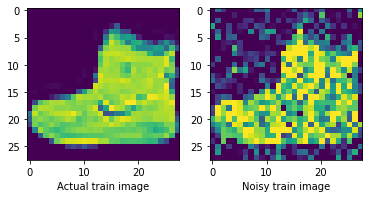

In [10]:
print('Sample of train noisy image')
plt.subplot(1,2,1)
plt.imshow(x_train[0])
plt.xlabel('Actual train image')
plt.subplot(1,2,2)
plt.imshow(noisy_train[0])
plt.xlabel('Noisy train image')
plt.show()

Sample of test noisy image


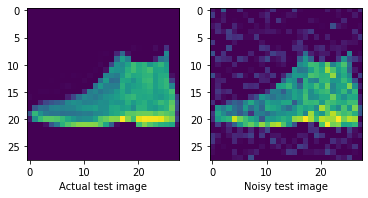

In [11]:
# adding noise to test set(noise_factor = 0.1 is taken)
noisy_test = add_noise(x_test, 0.1)
print('Sample of test noisy image')
plt.subplot(1,2,1)
plt.imshow(x_test[0])
plt.xlabel('Actual test image')
plt.subplot(1,2,2)
plt.imshow(noisy_test[0])
plt.xlabel('Noisy test image')
plt.show()

In [12]:
# converting noisy dataset list to a numpy array
noisy_train = np.array(noisy_train)
noisy_test = np.array(noisy_test)

# Build and Train the Autoencoder CNN base Deep Learning model

## Building the Sequential network

Summary of the network
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 8)           1160      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 16)        1168      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         145       
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________


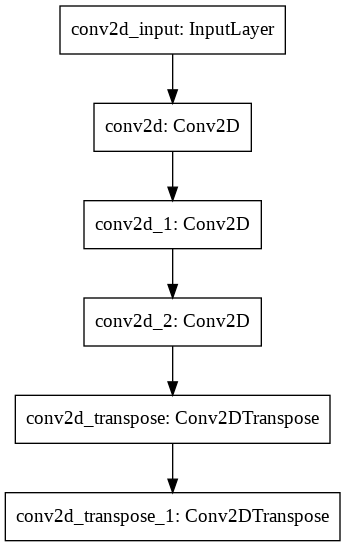

In [13]:
autoencoder = keras.models.Sequential()

# encoder network
autoencoder.add(keras.layers.Conv2D(filters=16, kernel_size=3, strides=2, padding='same', input_shape = (28,28,1)))
autoencoder.add(keras.layers.Conv2D(filters=8, kernel_size=3, strides=2, padding='same'))

autoencoder.add(keras.layers.Conv2D(filters=8, kernel_size=3, strides=1, padding='same'))

# decoder network
# Conv2DTranspose does the transpose convolution operation
autoencoder.add(keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same'))
# output layer consists of single filter, as the input image has single image, so does the reconstructed output image
autoencoder.add(keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=2, activation='sigmoid', padding = 'same'))

print('Summary of the network')
autoencoder.summary()
plot_model(autoencoder)

 ## Model Compilation

 Adam optimizer is used, where loss = Binary crossentropy

In [14]:
autoencoder.compile(loss = 'binary_crossentropy', optimizer=Adam(lr = 0.001))

**Note:**

**Why binary cross_entropy used for tuning the autoencoder ?**

**[Answer](https://stackoverflow.com/questions/52441877/how-does-binary-cross-entropy-loss-work-on-autoencoders)**

## Model Training

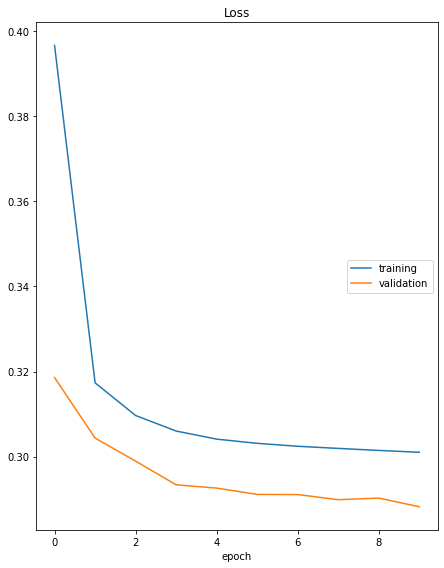

Loss
	training         	 (min:    0.301, max:    0.397, cur:    0.301)
	validation       	 (min:    0.288, max:    0.319, cur:    0.288)
300/300 [==============================] - 17s 57ms/step - loss: 0.3010 - val_loss: 0.2883


In [15]:
autoencoder.fit(noisy_train.reshape(-1,28,28,1),
                x_train.reshape(-1,28,28,1),
                epochs = 10,
                batch_size = 200,
                validation_data = (noisy_test.reshape(-1,28,28,1),x_test.reshape(-1,28,28,1)),
                callbacks = [PlotLossesCallback()],
                verbose = 1
                )

# Evaluate the Trained Model Performance

In [16]:
evaluation = autoencoder.evaluate(noisy_test.reshape(-1,28,28,1), x_test.reshape(-1,28,28,1))
print('Test loss: {0}'.format(evaluation))

313/313 [==============================] - 2s 5ms/step - loss: 0.2883
Test loss: 0.28825023770332336


# Visualization of Predicted Result

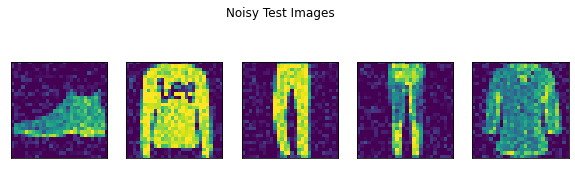

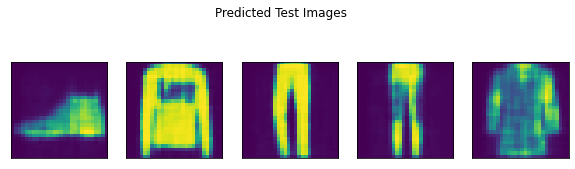

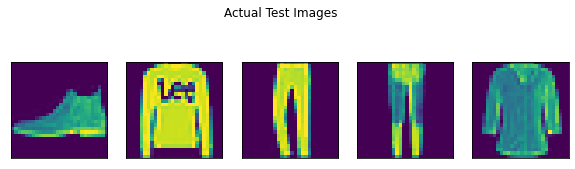

In [17]:
fig1 = plt.figure(figsize=(10,3))
fig1.suptitle('Noisy Test Images')
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(noisy_test[i].reshape(28,28))
  plt.xticks([])
  plt.yticks([])


fig2 = plt.figure(figsize=(10,3))
fig2.suptitle('Predicted Test Images')
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(autoencoder.predict(noisy_test.reshape(-1,28,28,1))[i].reshape(28,28))
  plt.xticks([])
  plt.yticks([])

fig3 = plt.figure(figsize=(10,3))
fig3.suptitle('Actual Test Images')
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(x_test[i].reshape(28,28))
  plt.xticks([])
  plt.yticks([])

plt.show()